In [1]:
#Imports: #TODO wohin mit den restlichen Files? sorted_cluster_ids.csv, model etc?
from models.GAN.Conditional.CHybridGAN import BasicEmbeddingCManyToManyHybridLSTMWFFGAN
import pandas as pd
import numpy as np
import dataprep_utils
import torch
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
#Step1: load model:
#Models included are the models from the last challenge. d4g: trained on data4grid noPV: trained on private of Openmeter without pv private: trained on private openemeter gewoeff: trainined on gewerblich and oeffentlich of openmeter
path = "BasicEmbeddingCManyToManyHybridLSTMWFFGAN20-02-2024-05-52-33_private.pt" #maybe needs to be changed to an absolute path that points to the .pt file containing the model.
device = "cpu" #possible values: 'cpu' (for cpu computation (slower)), 'cuda' (for GPU-compute (model is relativly small so no insane GPUs should be required)), 'cuda:1' (for selecting the second gpu if there a multiple), etc
model = BasicEmbeddingCManyToManyHybridLSTMWFFGAN.loadModel(path, device=device)# since we only use one model this always stays the same

In [3]:
#Step2: Define conditions:
seq_length = 96 #one day. Can be arbitrarily long, longer sequences could yield worse results. The way I did the contest data was produce single days and concatanate them (works cause of the conditions)
#time
#define length of the observations (has to be devidable by the seq_length. In this case 35040 Timesteps / 96 = 365 days)
index = pd.date_range(start="2021-01-01 00:00:00", end="2021-12-31 23:45:00", freq="15min")
print(len(index))
contCond = dataprep_utils.getDayPeriodicEmbedding(index)
contCond = np.append(contCond, dataprep_utils.getWeekPeriodicEmbedding(index), axis=1)
contCond = np.append(contCond, dataprep_utils.getYearPeriodicEmbedding(index), axis=1)
contCond = np.append(contCond, dataprep_utils.getSummertimes(index).reshape(-1,1), axis=1)
#households:
households = [0,1,5,10,400,443]#Householdis had to be converted to integers for the model. They are just enumerated in the same order as they appear in the dataset. Max value is the number of households in the dataset, that the model was trained on - 1 (cause we start at 0). Mappings from id as String to id as int could be given in the future but I didn't build one as of now.
#clusterids
le = LabelEncoder()
le.classes_ = np.load("clusteridsprivate.labelencoder.npy")
cluster_labels_csv = pd.read_csv("sorted_cluster_ids_private.csv")
cluster_ids = []
for id in households:
    cluster_ids.append(cluster_labels_csv.label[id])
#temperature
temp_mean = 283.691026
temp_std = 7.727334
weather_data =  np.array([284.691026]).repeat(len(index))# fake data to give example
tempdata = (weather_data - temp_mean) / temp_std
contCond = np.append(contCond, tempdata.reshape(-1,1), axis=1)
contCond = torch.from_numpy(contCond.reshape((-1, seq_length, contCond.shape[1]))).to(torch.float32).to(device)

35040


In [4]:
#Step3: Generate the data
num_households = len(households)
series = torch.empty(size=(num_households, len(index)))
for i, id in enumerate(households):
    print(id)
    catCond = np.empty((len(index), 0))
    catCond = np.append(catCond, np.array(le.transform([cluster_ids[i]])).repeat(len(index)).reshape(-1,1), axis=1)
    catCond = np.append(catCond, np.array([i]).repeat(len(index)).reshape(-1,1), axis=1)
    catCond = torch.from_numpy(catCond.reshape(-1,seq_length, catCond.shape[1])).to(torch.int32).to(device)#expands the condition of the householdid and clusterid to every timestep so that the model always has the info.
    series[i] = model.generator.getSample(catCond.shape[0], seq_length, catCond, contCond).detach().cpu().flatten()#generates the data
print(series)
#Last thing would be to rescale the timeseries (I forgot about that, will be possible later, if I get to it it will be done in the gerationprocess, else we have to use a dict that knows the values for the individual householdids). The timeseries that are generated are standardizted to the range ~[0,1], but the shape is there.
#If you want to rescale them manualy now, take the datasets that the model was trained on, and if you want to rescale the household with id (number) 10 take the tenth household in that dataset, get the nan_max and nan_min values and rescale them with these values (rescaled = original * (max - min) + min)

0
1
5
10
400
443
tensor([[0.0532, 0.0570, 0.0475,  ..., 0.0847, 0.0586, 0.0745],
        [0.0357, 0.0369, 0.0371,  ..., 0.0291, 0.0294, 0.0282],
        [0.0891, 0.0672, 0.0607,  ..., 0.0803, 0.0831, 0.0756],
        [0.0433, 0.0454, 0.0455,  ..., 0.0150, 0.0112, 0.0221],
        [0.0254, 0.0227, 0.0208,  ..., 0.0390, 0.0348, 0.0349],
        [0.0131, 0.0200, 0.0231,  ..., 0.0821, 0.0726, 0.1109]])


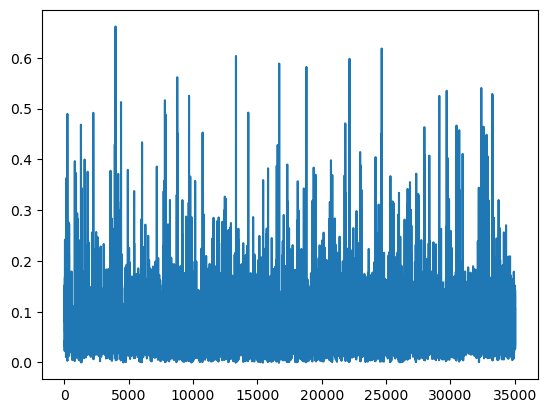

In [5]:
#Step 4: Profit (now the data can be stored or whatever)
#For further questions feel free to ask.

plt.plot(series[1,:])
plt.show()